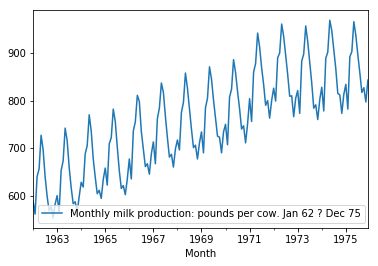

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Download dataset from this-->https://datamarket.com/data/set/22ox/#!ds=22ox&display=line
milk = pd.read_csv('monthly-milk-production-pounds-p.csv',index_col="Month")

milk.index = pd.to_datetime(milk.index) #convert index to time series
milk.plot()

In [10]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Monthly milk production: pounds per cow. Jan 62 ? Dec 75    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [31]:
train_data = milk.head(156)
test_data = milk.tail(12)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaler = scaler.fit_transform(train_data)
test_scaler = scaler.transform(test_data)

def batch_data(traind_set,batch_size,steps):
    rand_value = np.random.randint(0,len(traind_set)-steps)
    y_batch = np.array(traind_set[rand_value:rand_value+steps+1]).reshape(1,steps+1)
    return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

import tensorflow as tf
num_input = 1
num_time_step = 12
num_output = 1
num_neuron = 100
learning_rate = 0.03
num_iteration = 4000
batch_size = 1

tf.reset_default_graph()

x = tf.placeholder(tf.float32,[None,num_time_step,num_input])
y = tf.placeholder(tf.float32,[None,num_time_step,num_output])

cell =tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neuron,activation=tf.nn.relu),output_size=num_output)

output, state = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
loss = tf.reduce_mean(tf.square(output-y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_iteration):
        
        x_batch ,y_batch = batch_data(train_scaler,batch_size,num_time_step)
        sess.run(train,feed_dict={x:x_batch,y:y_batch})
        
        if iteration %100 ==0:
            mse =loss.eval(feed_dict={x:x_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
            
    saver.save(sess,"./time_series_model")

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0 	MSE 0.13727064
100 	MSE 0.014550519
200 	MSE 0.012212553
300 	MSE 0.013289112
400 	MSE 0.007306056
500 	MSE 0.0071763583
600 	MSE 0.0040607853
700 	MSE 0.0046490575
800 	MSE 0.005889403
900 	MSE 0.0045243558
1000 	MSE 0.0064218845
1100 	MSE 0.00566509
1200 	MSE 0.0077135437
1300 	MSE 0.0031500496
1400 	MSE 0.0030941914
1500 	MSE 0.004085382
1600 	MSE 0.0053170393
1700 	MSE 0.007496903
1800 	MSE 0.0058056302
1900 	MSE 0.0027177616
2000 	MSE 0.0043930137
2100 	MSE 0.007316081
2200 	MSE 0.0036405148
2300 	MSE 0.0024611955
2400 	MSE 0.0040795337
2500 	MSE 0.007707725
2600 	MSE 0.004475094
2700 	MSE 0.0017753415
2800 	MSE 0.0067230347
2900 	MSE 0.0057450645
3000 	MSE 0.0020749725
3100 	MSE 0.002083172
3200 	MSE 0.0058239126
3300 	MSE 0.004853603
3400 	MSE 0.0060842815
3500 	MSE 0.004448335
3600 	MSE 0.011129078
3700 	MSE 0.00554801
3800 	MSE 0.001935826
3900 	MSE 0.009586468


In [35]:
with tf.Session() as sess:
    saver.restore(sess,"./time_series_model")
    train_seed = list(train_scaler[-12:])
    
    for iteration in range(12):
        x_batch = np.array(train_seed[-num_time_step:]).reshape(1,num_time_step,1)
        y_predict = sess.run(output,feed_dict={x:x_batch})
        train_seed.append(y_predict[0,-1,0])

INFO:tensorflow:Restoring parameters from ./time_series_model


In [44]:
result =scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

test_data['generated'] = result
test_data

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Monthly milk production: pounds per cow. Jan 62 ? Dec 75,generated
Month,,
1975-01-01,834,793.567444
1975-02-01,782,774.258179
1975-03-01,892,794.476501
1975-04-01,903,803.922180
1975-05-01,966,757.451172
1975-06-01,937,831.064087
1975-07-01,896,836.888062
1975-08-01,858,850.136963
1975-09-01,817,824.541016


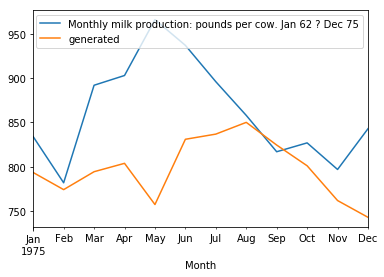

In [45]:
test_data.plot()